In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact
import scipy.sparse as sp_sparse
from scipy.special import expit as sigmoid
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [2]:
aragwas = pd.concat(
    [
        pd.read_csv(
            f"output/aragwas/api_chr{chrom}.csv.gz",
            usecols=[
                "snp.chr",
                "snp.position",
                "snp.ref",
                "snp.alt",
                "score",
                "maf",
                "mac",
                "study.name",
                "study.phenotype.name",
                "overBonferroni",
                "overPermutation",
            ],
        ).rename(
            columns={
                "snp.chr": "chrom",
                "snp.position": "pos",
                "snp.ref": "ref",
                "snp.alt": "alt",
                "score": "aragwas_score",
            }
        )
        for chrom in ["1", "2", "3", "4", "5"]
    ],
    # axis=1,
    ignore_index=True,
)
aragwas.chrom = aragwas.chrom.str.replace("chr", "")
aragwas

,chrom,pos,aragwas_score,maf,mac,study.name,study.phenotype.name,overBonferroni,overPermutation,ref,alt
0,1,16653911,43.734411,0.051896,26,"('clim-gs10_raw_Full imputed genotype_amm',)",clim-gs10,True,True,A,C
1,1,16634821,35.267820,0.051896,26,"('clim-gs10_raw_Full imputed genotype_amm',)",clim-gs10,True,True,G,A
2,1,16634858,35.267820,0.051896,26,"('clim-gs10_raw_Full imputed genotype_amm',)",clim-gs10,True,True,G,A
3,1,16601028,34.882685,0.051896,26,"('clim-gs10_raw_Full imputed genotype_amm',)",clim-gs10,True,True,T,G
4,1,16602311,32.632170,0.047904,24,"('clim-gs10_raw_Full imputed genotype_amm',)",clim-gs10,True,True,C,T
...,...,...,...,...,...,...,...,...,...,...,...
1225243,5,9055418,4.000051,0.041916,21,"('clim-bio13_raw_Full imputed genotype_amm',)",clim-bio13,False,False,C,T
1225244,5,9056844,4.000051,0.041916,21,"('clim-bio13_raw_Full imputed genotype_amm',)",clim-bio13,False,False,C,T
1225245,5,15646309,4.000035,0.013972,7,"('clim-prec3_raw_Full imputed genotype_amm',)",clim-prec3,False,False,C,T
1225246,5,7726496,4.000002,0.437126,219,"('clim-prec5_raw_Full imputed genotype_amm',)",clim-prec5,False,False,C,A


In [3]:
full_aragwas = aragwas.copy()

In [4]:
aragwas = (
    aragwas.groupby(["chrom", "pos", "ref", "alt"])
    .agg(
        {
            "aragwas_score": "max",
            "overBonferroni": "any",
            "overPermutation": "any",
            "study.phenotype.name": "unique",
        }
    )
    .reset_index()
)
aragwas

,chrom,pos,ref,alt,aragwas_score,overBonferroni,overPermutation,study.phenotype.name
0,1,221,A,G,5.550565,False,False,"[clim-gs10, clim-bio4, clim-aet5]"
1,1,667,C,T,5.550565,False,False,"[clim-gs10, clim-bio4, clim-aet5]"
2,1,754,C,T,4.653143,False,False,"[clim-gs5, clim-aet12, clim-aet1]"
3,1,774,A,T,5.550565,False,False,"[clim-gs10, clim-bio4, clim-aet5]"
4,1,1089,C,A,4.607782,False,False,"[clim-gs10, clim-bio4, clim-aet6]"
...,...,...,...,...,...,...,...,...
510589,5,26974716,A,G,14.217024,True,True,"[clim-bio4, clim-bio7, clim-gs10, clim-tmin2, ..."
510590,5,26975046,A,G,4.209524,False,False,[Leaf roll 22]
510591,5,26975053,G,A,5.623626,False,False,[ScalingExponent]
510592,5,26975121,G,A,4.691377,False,False,"[deltaRGR P Fe norm on Fe norm, RGR P Fe norm]"


In [5]:
d = Path(f"output/variants/all")

In [6]:
# sgkit has square values, and upper triangular
# vs. others
LD_path = "output/aragwas/LD_100000_0.1.npz"
LD = sp_sparse.load_npz(LD_path)
LD

<510462x510462 sparse matrix of type '<class 'numpy.float32'>'
	with 26273275 stored elements in Compressed Sparse Row format>

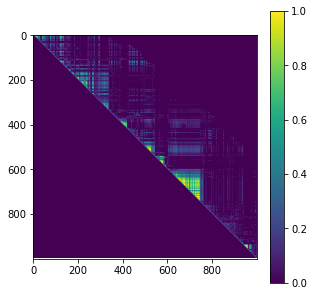

In [7]:
plt.figure(figsize=(5, 5))
plt.imshow(LD[:1000, :1000].toarray())
plt.colorbar()

In [8]:
def make_symmetric(A):
    return A + A.T - sp_sparse.diags(A.diagonal())


def sparsify(A, threshold):
    B = A.copy()
    B.data[B.data < threshold] = 0
    B.eliminate_zeros()
    return B


def square(A):
    B = A.copy()
    B.data = np.square(B.data)
    return B


# no need to make symmetric for LD vs. distance


LD = make_symmetric(LD)  # for the ones from sgkit
# LD = square(LD)
LD

<510462x510462 sparse matrix of type '<class 'numpy.float32'>'
	with 52036088 stored elements in Compressed Sparse Row format>

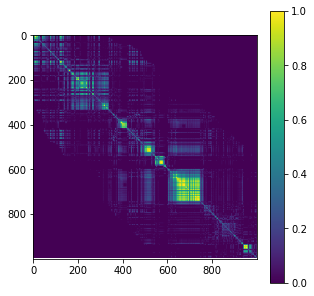

In [9]:
plt.figure(figsize=(5, 5))
plt.imshow(LD[:1000, :1000].toarray())
plt.colorbar()

In [70]:
models = [
    # "ConvNet_batch2048_weight1.0_secondpart_30k",
    "ConvNet_batch2048_secondpart_30k",
    # "ConvNet_batch2048_weight0_secondpart_30k",
    # "vep/scratch/users/gbenegas/checkpoints/GPN_Arabidopsis_multispecies/ConvNet_ss_12k/checkpoint-12000",
    "phyloP",
    "phastCons",
]
add_ld_score = True

model_renaming = {
    "ConvNet_batch2048_secondpart_30k": "GPN",
    # "ConvNet_batch2048_secondpart_30k": "repeat-weight-0.1",
    # "ConvNet_batch2048_secondpart_30k": "8 species",
    "ConvNet_batch2048_weight1.0_secondpart_30k": "repeat-weight-1",
    "ConvNet_batch2048_weight0_secondpart_30k": "repeat-weight-0",
    "vep/scratch/users/gbenegas/checkpoints/GPN_Arabidopsis_multispecies/ConvNet_ss_12k/checkpoint-12000": "1 species",
}

V = pd.read_parquet(d / "variants.parquet")

for m in models:
    model_path = d / f"{m}.parquet"
    model_name = model_renaming.get(m, m)
    V[model_name] = pd.read_parquet(model_path)["score"].values
if add_ld_score:
    V["1"] = -np.ones(len(V))
    models.append("1")

# experimental
V = pd.concat(
    [
        V,
        pd.read_parquet(
            "output/variants/all/vep_embeddings/gonzalobenegas/gpn-brassicales.parquet"
        ),
    ],
    axis=1,
)
models += ["euclidean_distance", "inner_product", "cosine_similarity"]

models = [model_renaming.get(m, m) for m in models]
V = V.merge(aragwas, how="inner", on=["chrom", "pos", "ref", "alt"], sort=True)
SIGNIFICANCE_COL = "overPermutation"
# SIGNIFICANCE_COL = "overBonferroni"
V["% SNPs are GWAS hits"] = 100 * V[SIGNIFICANCE_COL]
repeats = pd.read_csv("input/repeats.bed.gz", sep="\t").rename(
    columns=dict(genoName="chrom", genoStart="start", genoEnd="end")
)
repeats.chrom = repeats.chrom.str.replace("Chr", "")
V["start"] = V.pos
V["end"] = V.start + 1
V = bf.coverage(V, repeats).rename(columns={"coverage": "repeat"})
V.repeat = V.repeat.astype(bool)
V

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/bioframe/core/specs.py:150: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  pd.api.types.is_categorical_dtype(chrom_dtype),
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/bioframe/core/specs.py:150: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  pd.api.types.is_categorical_dtype(chrom_dtype),
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/bioframe/core/specs.py:150: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  pd.api.types.is_categorical_dtype(chrom_dtype),


,chrom,pos,ref,alt,AC,AF,consequence,GPN,phyloP,phastCons,...,inner_product,cosine_similarity,aragwas_score,overBonferroni,overPermutation,study.phenotype.name,% SNPs are GWAS hits,start,end,repeat
0,1,667,C,T,17,0.008379,intergenic_variant,0.635977,-0.062359,-0.001166,...,18677372.0,0.998133,5.550565,False,False,"[clim-gs10, clim-bio4, clim-aet5]",0,667,668,False
1,1,754,C,T,49,0.024150,intergenic_variant,-0.685284,-0.017141,-0.001879,...,18254720.0,0.996607,4.653143,False,False,"[clim-gs5, clim-aet12, clim-aet1]",0,754,755,False
2,1,774,A,T,17,0.008379,intergenic_variant,0.369063,-1.045575,-0.045978,...,18450596.0,0.997639,5.550565,False,False,"[clim-gs10, clim-bio4, clim-aet5]",0,774,775,False
3,1,1089,C,A,19,0.009364,intergenic_variant,-2.765268,-0.000000,-0.079773,...,17653270.0,0.997911,4.607782,False,False,"[clim-gs10, clim-bio4, clim-aet6]",0,1089,1090,True
4,1,1420,T,A,20,0.009857,intergenic_variant,-0.115594,-0.713984,-0.012492,...,16960628.0,0.997918,4.236610,False,False,[GR21 cold],0,1420,1421,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510457,5,26974716,A,G,63,0.031050,intergenic_variant,-1.170408,0.340025,-0.018862,...,17837668.0,0.997531,14.217024,True,True,"[clim-bio4, clim-bio7, clim-gs10, clim-tmin2, ...",100,26974716,26974717,False
510458,5,26975046,A,G,1701,0.838344,intergenic_variant,-1.260575,0.388070,-0.021325,...,19932708.0,0.995974,4.209524,False,False,[Leaf roll 22],0,26975046,26975047,False
510459,5,26975053,G,A,13,0.006407,intergenic_variant,0.812610,0.662208,-0.017237,...,19974528.0,0.996736,5.623626,False,False,[ScalingExponent],0,26975053,26975054,False
510460,5,26975121,G,A,73,0.035978,intergenic_variant,0.303412,1.284491,-0.000038,...,19832024.0,0.994582,4.691377,False,False,"[deltaRGR P Fe norm on Fe norm, RGR P Fe norm]",0,26975121,26975122,False


In [71]:
V[["GPN", "cosine_similarity", "inner_product", "euclidean_distance"]].corr(
    method="spearman"
)

,GPN,cosine_similarity,inner_product,euclidean_distance
GPN,1.000000,0.089302,-0.107230,-0.135312
cosine_similarity,0.089302,1.000000,0.093649,-0.944306
inner_product,-0.107230,0.093649,1.000000,0.176331
euclidean_distance,-0.135312,-0.944306,0.176331,1.000000


In [72]:
if "phyloP" in models:
    V["abs(phyloP)"] = -V["phyloP"].abs()
    models.append("abs(phyloP)")

In [73]:
for m in models:
    if m not in [
        "1",
        "phyloP",
        "phastCons",
        "abs(phyloP)",
        "cosine_similarity",
        "inner_product",
    ]:
        V[m] = -V[m].abs()

In [74]:
V[models].isna().mean()

GPN                   0.000000
phyloP                0.112018
phastCons             0.112018
1                     0.000000
euclidean_distance    0.000000
inner_product         0.000000
cosine_similarity     0.000000
abs(phyloP)           0.112018
dtype: float64

In [75]:
not_na = ~V[models].isna().any(axis=1)
V = V[not_na].copy()
idx_not_na = np.where(not_na)[0]
LD2 = LD[idx_not_na][:, idx_not_na]
V[models].isna().mean()

GPN                   0.0
phyloP                0.0
phastCons             0.0
1                     0.0
euclidean_distance    0.0
inner_product         0.0
cosine_similarity     0.0
abs(phyloP)           0.0
dtype: float64

In [76]:
def transform(score, name):
    if name == "1":
        return score
    return score - score.max()


for m in models:
    V[m] = transform(V[m], m)

In [77]:
V["GPN*euclidean_distance"] = -(V.GPN * V.euclidean_distance)
models.append("GPN*euclidean_distance")
V["GPN*cosine_similarity"] = -(V.GPN * V.cosine_similarity)
models.append("GPN*cosine_similarity")
V

,chrom,pos,ref,alt,AC,AF,consequence,GPN,phyloP,phastCons,...,overBonferroni,overPermutation,study.phenotype.name,% SNPs are GWAS hits,start,end,repeat,abs(phyloP),GPN*euclidean_distance,GPN*cosine_similarity
0,1,667,C,T,17,0.008379,intergenic_variant,-0.635977,-8.301850,-0.001166,...,False,False,"[clim-gs10, clim-bio4, clim-aet5]",0,667,668,False,-0.062359,-70.753548,-0.000940
1,1,754,C,T,49,0.024150,intergenic_variant,-0.685283,-8.256632,-0.001879,...,False,False,"[clim-gs5, clim-aet12, clim-aet1]",0,754,755,False,-0.017141,-136.385040,-0.002058
2,1,774,A,T,17,0.008379,intergenic_variant,-0.369062,-9.285066,-0.045978,...,False,False,"[clim-gs10, clim-bio4, clim-aet5]",0,774,775,False,-1.045575,-52.666168,-0.000728
3,1,1089,C,A,19,0.009364,intergenic_variant,-2.765268,-8.239491,-0.079773,...,False,False,"[clim-gs10, clim-bio4, clim-aet6]",0,1089,1090,True,0.000000,-324.739838,-0.004699
4,1,1420,T,A,20,0.009857,intergenic_variant,-0.115593,-8.953475,-0.012492,...,False,False,[GR21 cold],0,1420,1421,False,-0.713984,-13.092086,-0.000196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510457,5,26974716,A,G,63,0.031050,intergenic_variant,-1.170407,-7.899466,-0.018862,...,True,True,"[clim-bio4, clim-bio7, clim-gs10, clim-tmin2, ...",100,26974716,26974717,False,-0.340025,-167.372910,-0.002435
510458,5,26975046,A,G,1701,0.838344,intergenic_variant,-1.260575,-7.851421,-0.021325,...,False,False,[Leaf roll 22],0,26975046,26975047,False,-0.388070,-313.315186,-0.004584
510459,5,26975053,G,A,13,0.006407,intergenic_variant,-0.812610,-7.577284,-0.017237,...,False,False,[ScalingExponent],0,26975053,26975054,False,-0.662208,-169.714569,-0.002336
510460,5,26975121,G,A,73,0.035978,intergenic_variant,-0.303412,-6.955000,-0.000038,...,False,False,"[deltaRGR P Fe norm on Fe norm, RGR P Fe norm]",0,26975121,26975122,False,-1.284491,-85.423988,-0.001526


In [78]:
def LD_profile(LD, score):
    return LD @ score


for model in models.copy():
    name = rf"{model}$\times$LD" if model != "1" else "LD Score"
    V[name] = LD_profile(LD2, V[model])
    models.append(name)
V

,chrom,pos,ref,alt,AC,AF,consequence,GPN,phyloP,phastCons,...,GPN$\times$LD,phyloP$\times$LD,phastCons$\times$LD,LD Score,euclidean_distance$\times$LD,inner_product$\times$LD,cosine_similarity$\times$LD,abs(phyloP)$\times$LD,GPN*euclidean_distance$\times$LD,GPN*cosine_similarity$\times$LD
0,1,667,C,T,17,0.008379,intergenic_variant,-0.635977,-8.301850,-0.001166,...,-43.951603,-431.786896,-8.018026,-52.271317,-7938.765137,-8.984840e+08,-0.127869,-33.090939,-6961.883789,-0.113794
1,1,754,C,T,49,0.024150,intergenic_variant,-0.685283,-8.256632,-0.001879,...,-1.797570,-20.445386,-0.350290,-2.428263,-323.165344,-3.961019e+07,-0.004691,-0.466916,-225.668442,-0.003239
2,1,774,A,T,17,0.008379,intergenic_variant,-0.369062,-9.285066,-0.045978,...,-43.951603,-431.786896,-8.018026,-52.271317,-7938.765137,-8.984840e+08,-0.127869,-33.090939,-6961.883789,-0.113794
3,1,1089,C,A,19,0.009364,intergenic_variant,-2.765268,-8.239491,-0.079773,...,-39.997417,-388.805446,-7.268364,-47.081977,-7138.247070,-8.095016e+08,-0.114940,-29.730035,-6310.637207,-0.103032
4,1,1420,T,A,20,0.009857,intergenic_variant,-0.115593,-8.953475,-0.012492,...,-4.623837,-49.009423,-1.217644,-5.860228,-958.525635,-9.719814e+07,-0.014352,-3.935239,-683.981445,-0.009343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510457,5,26974716,A,G,63,0.031050,intergenic_variant,-1.170407,-7.899466,-0.018862,...,-92.828979,-831.154524,-22.586723,-99.974218,-13971.743164,-1.732978e+09,-0.216179,-80.233605,-13909.292969,-0.221661
510458,5,26975046,A,G,1701,0.838344,intergenic_variant,-1.260575,-7.851421,-0.021325,...,-16.178766,-131.622528,-3.711545,-15.817500,-2274.978516,-2.720483e+08,-0.034768,-12.167352,-2576.150635,-0.039662
510459,5,26975053,G,A,13,0.006407,intergenic_variant,-0.812610,-7.577284,-0.017237,...,-6.919710,-62.893254,-0.866401,-7.131219,-1363.530029,-1.227189e+08,-0.021630,-6.015245,-1519.781250,-0.023987
510460,5,26975121,G,A,73,0.035978,intergenic_variant,-0.303412,-6.955000,-0.000038,...,-4.858538,-58.104145,-0.969295,-7.220275,-1171.022095,-1.230900e+08,-0.018523,-3.920983,-747.015747,-0.011352


In [79]:
"""
results = []
for m in ["GPN", r"GPN$\times$LD"]:
    df = V[["% SNPs are GWAS hits"]].copy()
    df["Model"] = m
    df["Percentile bin"] = pd.qcut(V[m], 100, labels=False)
    results.append(df)
results = pd.concat(results)

g = sns.relplot(
    data=results,
    x="Percentile bin",
    y="% SNPs are GWAS hits",
    row="Model",
    errorbar=None,
    kind="line",
    facet_kws=dict(sharey=False, sharex=False),
    height=2.3,
)#.set_titles(row_template="{row_name}")

# Loop through each axes (i.e., subplot) and set its x-label
for i, ax in enumerate(g.axes.flat):
    ax.set_xlabel(f"Percentile bin of {results['Model'].unique()[i]}")

# Remove the overall title
#g.fig.subplots_adjust(top=0.9)  # adjust the Figure in rp

# Don't use the original titles (since we're replacing with custom labels)
g.set_titles("")


#plt.savefig("output/plots/ld_profile.svg", bbox_inches='tight');
"""

'\nresults = []\nfor m in ["GPN", r"GPN$\times$LD"]:\n    df = V[["% SNPs are GWAS hits"]].copy()\n    df["Model"] = m\n    df["Percentile bin"] = pd.qcut(V[m], 100, labels=False)\n    results.append(df)\nresults = pd.concat(results)\n\ng = sns.relplot(\n    data=results,\n    x="Percentile bin",\n    y="% SNPs are GWAS hits",\n    row="Model",\n    errorbar=None,\n    kind="line",\n    facet_kws=dict(sharey=False, sharex=False),\n    height=2.3,\n)#.set_titles(row_template="{row_name}")\n\n# Loop through each axes (i.e., subplot) and set its x-label\nfor i, ax in enumerate(g.axes.flat):\n    ax.set_xlabel(f"Percentile bin of {results[\'Model\'].unique()[i]}")\n\n# Remove the overall title\n#g.fig.subplots_adjust(top=0.9)  # adjust the Figure in rp\n\n# Don\'t use the original titles (since we\'re replacing with custom labels)\ng.set_titles("")\n\n\n#plt.savefig("output/plots/ld_profile.svg", bbox_inches=\'tight\');\n'

In [80]:
ld_models = [m for m in models if "LD" in m]
ld_models

['GPN$\\times$LD',
 'phyloP$\\times$LD',
 'phastCons$\\times$LD',
 'LD Score',
 'euclidean_distance$\\times$LD',
 'inner_product$\\times$LD',
 'cosine_similarity$\\times$LD',
 'abs(phyloP)$\\times$LD',
 'GPN*euclidean_distance$\\times$LD',
 'GPN*cosine_similarity$\\times$LD']

In [81]:
import warnings

warnings.filterwarnings("ignore")


def compute_odds_ratio(df, threshold_quantile, model_name):
    df = df.copy()
    threshold = df[model_name].quantile(threshold_quantile)
    df["ModelScoreTier"] = "NA"
    df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low"
    # df.loc[df[model_name] > df[model_name].quantile(0.1), "ModelScoreTier"] = "High"
    df.loc[df[model_name] > threshold, "ModelScoreTier"] = "High"
    df = df[df.ModelScoreTier.isin(["Low", "High"])]

    df.ModelScoreTier = df.ModelScoreTier.astype("category")
    group_counts = df.groupby([SIGNIFICANCE_COL, "ModelScoreTier"]).size()
    group_counts2 = group_counts.copy()
    # print(group_counts2); raise Exception("printing")
    group_counts = group_counts.loc[
        pd.MultiIndex.from_tuples(
            [[False, "High"], [False, "Low"], [True, "High"], [True, "Low"]]
        )
    ].values.reshape((2, 2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative="greater")
    if np.isinf(odds_ratio):
        print(model_name, odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts


threshold_quantiles = np.linspace(1e-2, 1e-1, 4)

rows = []
rows_subset = []

for tq in threshold_quantiles:
    for m in ld_models:
        # print(m, tq)
        OR, p_value, min_counts = compute_odds_ratio(V, tq, m)
        rows.append([m, tq, OR, p_value, min_counts])
results = pd.DataFrame(
    rows,
    columns=[
        "Model",
        "Threshold quantile",
        "Odds ratio",
        "p_value",
        "min_counts",
    ],
)
results["significant"] = results.p_value <= 0.05
results

,Model,Threshold quantile,Odds ratio,p_value,min_counts,significant
0,GPN$\times$LD,0.01,10.259958,0.000000e+00,1015,True
1,phyloP$\times$LD,0.01,5.937425,5.038615e-255,663,True
2,phastCons$\times$LD,0.01,1.830393,1.279559e-16,235,True
3,LD Score,0.01,6.088525,3.342516e-266,678,True
4,euclidean_distance$\times$LD,0.01,9.300862,0.000000e+00,942,True
5,inner_product$\times$LD,0.01,6.398068,5.524435e-288,705,True
6,cosine_similarity$\times$LD,0.01,10.337086,0.000000e+00,1018,True
7,abs(phyloP)$\times$LD,0.01,7.481255,0.000000e+00,798,True
8,GPN*euclidean_distance$\times$LD,0.01,18.384341,0.000000e+00,1500,True
9,GPN*cosine_similarity$\times$LD,0.01,17.495619,0.000000e+00,1454,True


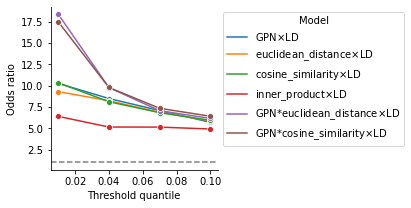

In [84]:
# """
plt.figure(figsize=(3, 3))
g = sns.lineplot(
    data=results[results.significant],
    x="Threshold quantile",
    y="Odds ratio",
    hue="Model",
    hue_order=[
        r"GPN$\times$LD",
        r"euclidean_distance$\times$LD",
        r"cosine_similarity$\times$LD",
        r"inner_product$\times$LD",
        r"GPN*euclidean_distance$\times$LD",
        r"GPN*cosine_similarity$\times$LD",
    ],
    # hue_order=[r"GPN$\times$LD", r"phyloP$\times$LD", r"phastCons$\times$LD", r"abs(phyloP)$\times$LD", "LD Score"],
    marker="o",
)
g.axhline(1, ls="--", color="grey")
sns.despine()
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));
# plt.savefig("output/plots/vep_gwas_line.pdf", bbox_inches='tight')
# """

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, '')

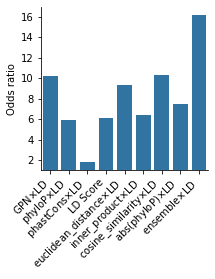

In [65]:
# plt.figure(figsize=(2,2))
plt.figure(figsize=(3, 3))

g = sns.barplot(
    data=results[(results.p_value <= 0.05) & (results["Threshold quantile"] == 1e-2)],
    x="Model",
    y="Odds ratio",
    # order=[r"GPN$\times$LD", r"phyloP$\times$LD", r"phastCons$\times$LD", r"abs(phyloP)$\times$LD", "LD Score"],
    # order=[r"GPN$\times$LD", r"phyloP$\times$LD", r"abs(phyloP)$\times$LD", "LD Score"],
    color="C0",
    # palette=["C0", "C1", "C3", "C4"],
)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right")
sns.despine()
g.set(ylim=(1))
# plt.title(f"All variants \n (n={len(V)})")
plt.xlabel("")
# plt.savefig("output/plots/vep_gwas_bar.svg", bbox_inches='tight');
# plt.savefig("output/plots/vep_gwas_bar_full.svg", bbox_inches='tight');
# plt.savefig("output/plots/vep_gwas_bar_repeat_weight.svg", bbox_inches='tight');
# plt.savefig("output/plots/vep_gwas_bar_n_species.svg", bbox_inches='tight');
# plt.savefig("output/plots/vep_gwas_bar_bonf.pdf", bbox_inches='tight');

In [59]:
V.shape

(453281, 25)

In [60]:
results[(results["Threshold quantile"] == 1e-2)]

,Model,Threshold quantile,Odds ratio,p_value,min_counts,significant
0,GPN$\times$LD,0.01,4.686085,0.000000e+00,1482,True
1,phyloP$\times$LD,0.01,2.410116,4.503331e-103,914,True
2,phastCons$\times$LD,0.01,0.954248,8.242013e-01,417,False
3,LD Score,0.01,2.468197,6.106866e-110,933,True
4,abs(phyloP)$\times$LD,0.01,3.458327,2.289583e-235,1200,True


In [61]:
raise Exception()

Exception: 

## Interpreting specific associations

In [ ]:
top_phenotypes = (
    full_aragwas["study.phenotype.name"].value_counts().head(10).index.values
)
full_aragwas.groupby(["study.phenotype.name", "overPermutation"]).size().loc[
    top_phenotypes
]

In [ ]:
target_phenotype = "clim-tmax1"
target_gwas = full_aragwas[full_aragwas["study.phenotype.name"] == target_phenotype]
target_gwas.overPermutation.value_counts()

In [ ]:
V["original_index"] = V.index
V_gwas = (
    V.drop(
        columns=[
            "aragwas_score",
            "overBonferroni",
            "overPermutation",
            "study.phenotype.name",
        ]
    )
    .merge(target_gwas, how="inner", on=["chrom", "pos", "ref", "alt"])
    .set_index("original_index")
)
V_gwas.overPermutation.value_counts()

In [ ]:
V_gwas["GWAS hit"] = V_gwas.overPermutation.replace({True: "Yes", False: "No"})
V_gwas["Chromosome position"] = V_gwas.pos


def plot_V_profile(vs, scores, save_path=None):
    # plt.figure(figsize=(4,3))
    ld_with_target = (
        LD[vs.sort_values(scores[0]).index.values[0]][:, vs.index.values]
        .toarray()
        .ravel()
        .round(decimals=1)
    )
    print(ld_with_target)
    ld_col = r"""$r^2$ w/ lowest
GPN score"""
    vs[ld_col] = ld_with_target

    vs = pd.melt(
        vs,
        ["chrom", "Chromosome position", "ref", "alt", "GWAS hit", ld_col],
        scores,
        "Model",
        "Score",
    )
    sns.set_style("darkgrid")  # dark  # to show the high ld with contrast
    g = sns.relplot(
        data=vs,
        x="Chromosome position",
        y="Score",
        row="Model",
        # hue="GWAS hit", hue_order=[True, False], palette="Dark2",
        style="GWAS hit",
        style_order=["Yes", "No"],
        markers=["o", "X"],  # markers=["X", "."],
        hue=ld_col,
        palette="viridis",
        # hue="GWAS hit", hue_order=["Yes", "No"], palette={"Yes": "g", "No": "r"},
        kind="scatter",
        facet_kws={"sharey": False, "sharex": True},
        height=2,
        aspect=1.6,
        s=100,
    )
    g.map(lambda **kwargs: plt.axhline(y=0, color="grey", linestyle="--"))
    g.set_titles(col_template="", row_template="")
    for i, score in enumerate(scores):
        g.axes[i, 0].set_ylabel(score)
    plt.subplots_adjust(hspace=0.1)
    # sns.move_legend(
    #    g, "lower center",
    #    bbox_to_anchor=(0.4, 0.9),
    #    ncol=2,
    # )

    # g.axhline(0, ls='--', color="grey")  # would need to map?
    # sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")


def plot_variant_profile(v, score, context=100, **kwargs):
    print(v.pos, context)
    vs = V_gwas[(V_gwas.pos >= v.pos - context) & (V_gwas.pos <= v.pos + context)]
    print(len(vs))
    plot_V_profile(vs, score, **kwargs)


def plot_ld_nearby(v, context=100):
    vs = V_gwas[(V_gwas.pos >= v.pos - context) & (V_gwas.pos <= v.pos + context)]
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        pd.DataFrame(
            LD[vs.index.values][:, vs.index.values].todense(),
            index=vs.overPermutation,
            columns=vs.overPermutation,
        ),
        square=True,
        xticklabels=True,
        yticklabels=True,
    )

In [ ]:
def top_LD_with_variant(v, k=3):
    row = LD.getrow(v.name)
    values = row.data
    indices = row.indices
    top_indices = indices[np.argsort(-values)[:k]]
    return V_gwas[V_gwas.index.isin(top_indices)]


def LD_max_dist_with_variant(v, threshold=0.7):
    print(LD[v.name, v.name])
    row = LD.getrow(v.name)
    values = row.data
    indices = row.indices
    top_indices = indices[values > threshold]
    vs = V_gwas[V_gwas.index.isin(top_indices)]
    return (v.pos - vs.pos).abs().max()

In [ ]:
# could also specify that there's no long-range LD (using a threshold)
# there's a lot of long-range LD, to bear in mind
# maybe filter the aragwas first for this
# would maybe have to re-do the GWAS analysis to avoid long-range LD? (maybe using a subset of phenotypes)
# by using PC's?
# or maybe do the filtering of LD matrix based on a radius myself?
# unclear what causes LD, to be honest.
# or maybe just don't show the fine-mapping... if there's long range LD
# the rest of the analysis is still good

# climtmax-1 interesting examples:
# chrom           5
# pos      10360998
# ref             T
# alt             A
# Name: 432170, dtype: object

for _, v in V_gwas.query("overPermutation").sort_values("GPN").head(30).iterrows():
    # print(v)
    # max_abs_dist = (v.pos - top_LD_with_variant(v, k=2).pos).abs().max()
    # print(max_abs_dist)
    if v.pos != 24505063:
        continue
    max_abs_dist = LD_max_dist_with_variant(v, 0.8)
    if np.isnan(max_abs_dist):
        print(v.name)
        raise Exception("debug")
    if max_abs_dist == 0 or max_abs_dist > 10_000:
        print("skipping")
        continue
    print(v)
    print(max_abs_dist)
    plot_variant_profile(
        v, ["GPN", r"GPN$\times$LD"], context=max_abs_dist + 10
    )  # , save_path="output/plots/gwas_example.svg")
    plt.show()
    plot_ld_nearby(v, context=max_abs_dist + 10)
    plt.show()

In [ ]:
V

In [ ]:
2 + 2